In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#!ls /content/gdrive

Mounted at /content/drive


In [3]:
# configuration
path = "/content/drive/My Drive/ECE324 Project/data/"
IMAGE_PATH = "/content/drive/My Drive/ECE324 Project/data/images/images/"

In [5]:
import pandas as pd
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from scipy.spatial.distance import cosine
import PIL
from PIL import Image

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)

class Identity(nn.Module): 
  def __init__(self):
    super(Identity, self).__init__()

  def forward(self,x):
    return x

class VGGMLP(nn.Module):
  def __init__(self):
    super(VGGMLP, self).__init__()
    # in-size 4096
    self.bn0 = nn.BatchNorm1d(4096)
    self.fc1 = nn.Linear(4096, 1024)
    self.bn1 = nn.BatchNorm1d(1024)
    self.rl1 = nn.LeakyReLU()
    # self.drop1 = nn.Dropout(0.05)
    # semantic output 1000
    self.fc2 = nn.Linear(1024, 1000)
    self.bn2 = nn.BatchNorm1d(1000)
    self.rl2 = nn.LeakyReLU()
    # self.drop2 = nn.Dropout(0.05)
    # output size 300
    self.fc3 = nn.Linear(1000, 300)
    self.rl3 = nn.LeakyReLU()

  def forward(self, features):
    # (4096, 1024)
    x = self.bn0(features)
    x = self.fc1(x)
    x = self.bn1(x)
    x = self.rl1(x)
    # x = self.drop1(x)
    # (1024, 1000)
    x = self.fc2(x)
    x = self.bn2(x)
    x = self.rl2(x)
    # x = self.drop2(x)
    # to be removed (1000, 300)
    x = self.fc3(x)
    x = self.rl3(x)
    return x



model = torch.load(path+"00_models/vgg_model_120.pt")
for param in model.parameters():
  param.requires_grad = False

model.fc3 = Identity()  # must output 1000 element vector
model.rl3 = Identity()
model.cuda()
print(model)

VGGMLP(
  (bn0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rl1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=1024, out_features=1000, bias=True)
  (bn2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rl2): LeakyReLU(negative_slope=0.01)
  (fc3): Identity()
  (rl3): Identity()
)


### Create database of recipe vectors

In [6]:
## Using training recipe vectors, store each in a dataframe
## Test recipes will look for the most similar vectors, and output its recipe
## We can later compare qualitatively how similar the recipes are
## Only need to run once
pd.set_option('display.max_columns', None)
t0 = pd.read_pickle(path + "vgg_train_dataframe0.plk")
t1 = pd.read_pickle(path + "vgg_train_dataframe1.plk")
t2 = pd.read_pickle(path + "vgg_train_dataframe2.plk")
t3 = pd.read_pickle(path + "vgg_train_dataframe3.plk")
train_dataframe = pd.concat([t0,t1,t2,t3], ignore_index=True)
print(train_dataframe)

                                             vgg_features  \
0       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.87...   
1       [[0.0, 0.5085418, 0.0, 0.0, 0.07914552, 0.0, 0...   
2       [[0.0, 0.18474162, 0.0, 0.0, 0.0, 0.15080066, ...   
3       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.59...   
4       [[0.0, 0.26950812, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
...                                                   ...   
199500  [[0.0, 2.010285, 1.4837028, 0.0, 0.0, 0.772197...   
199501  [[0.0, 1.4382131, 1.7284253, 0.0, 0.0, 0.0, 0....   
199502  [[0.0, 1.1971076, 1.2576761, 0.0, 0.0, 0.0, 0....   
199503  [[0.0, 1.9340289, 0.9830708, 0.0, 0.0, 1.03437...   
199504  [[0.0, 1.6834565, 1.4372649, 0.0, 0.0, 0.40382...   

                                                    label    code  
0       [0.001109877913429523, 0.001109877913429523, 0...   70006  
1       [0.001109877913429523, 0.001109877913429523, 0...   70006  
2       [0.001109877913429523, 0.001109877913429523, 0...   700

### Save database (only run once)

In [ ]:
train_dataframe['train'] = list(zip(train_dataframe.vgg_features, train_dataframe.code))
# print(train_dataframe)
# print(train_dataframe.shape)
# print((train_dataframe.iloc[0][0]).shape)
# print((train_dataframe.iloc[0][1]).shape)
# print((train_dataframe.iloc[0][3]))
db = pd.DataFrame()

for input, code in zip(train_dataframe['vgg_features'].values, train_dataframe['code'].values):
    # X = X.type(torch.cuda.FloatTensor)
    # y = y.type(torch.cuda.FloatTensor)
    output = model(torch.from_numpy(input).cuda())
    db = db.append([[output.cpu().numpy(), code]], ignore_index = True)

### Only run once ###
#db.to_pickle(path+"vgg16_base_database.plk")

### Load database, read test and val sets




In [9]:
db = pd.read_pickle(path+"vgg16_base_database.plk")
db.columns = ['vgg16_final_features','code']
print(db)
print(np.squeeze(db.iloc[0][0].shape))

# Test distance between points
# for i in range(20):
#   pt1 = np.squeeze(db.iloc[1][0])
#   pt2 = np.squeeze(db.iloc[i][0])
#   dist = np.linalg.norm(pt1-pt2)
#   print(dist,i)

testset = pd.read_pickle(path+"vgg_test_dataframe.plk")
valset = pd.read_pickle(path+"vgg_val_dataframe1.plk")

                                     vgg16_final_features    code
0       [[-0.0027829122, 0.013170614, -0.00021638836, ...   70006
1       [[-0.00319747, 0.068050176, 0.07668153, 0.0896...   70006
2       [[-0.0029774308, 0.023001831, 0.12440615, 0.07...   70006
3       [[-0.0011066573, -8.707235e-05, -0.00056331133...   70006
4       [[-0.006133222, 0.1648654, 0.18079656, -0.0008...   70006
...                                                   ...     ...
199500  [[0.03199102, -0.0017674505, -0.0023772472, -0...  266511
199501  [[-0.00011122048, -0.0012516534, -0.002153687,...  266511
199502  [[-0.0001574457, -0.0015527277, -0.002094695, ...  266511
199503  [[-0.00024937312, -0.0018274386, -0.0015789383...  266511
199504  [[-0.00035680903, -0.0016491347, -0.0013733335...  266511

[199505 rows x 2 columns]
[   1 1000]


### Load total data 

In [10]:
## Used to source the recipe. given the url code of the image
total_data = pd.read_excel(path + 'total_data2.xlsx')
total_data.columns = ['index','title','image source','time','serving size','ingredients','recipe','code']
print(total_data.columns)
print(total_data)

Index(['index', 'title', 'image source', 'time', 'serving size', 'ingredients',
       'recipe', 'code'],
      dtype='object')
       index                                 title  \
0          1          Baked Mac and Cheese for One   
1          2                         Blonde Bobbie   
2          3                            Egg Butter   
3          4                            Beer Pizza   
4          5                  Microwave Lemon Curd   
...      ...                                   ...   
46898     21                     Love Potion No. 9   
46899     22      Pimiento Cheese and Tomato Bites   
46900     23  Wolfgang Puck's Cheeseburger Sliders   
46901     24    Instant PotÂ® Sweet Baby Back Ribs   
46902     25           Instant PotÂ® Zuppa Toscana   

                                            image source  time  \
0      https://imagesvc.meredithcorp.io/v3/mm/image?u...    30   
1      https://imagesvc.meredithcorp.io/v3/mm/image?u...     2   
2      https://imagesvc.m

### Test images one at a time (not used anymore, check below)

In [ ]:
# test_number = 18 #161 for pork roast

# testrow = testset.iloc[test_number]
# print(test)
# test_code = test[2]
# test_vect = test['vgg_features']
# test_vect = model(torch.from_numpy(test_vect).cuda()).cpu().numpy()

# #print(test)
# #print(test_code)

# best_fit = [0, float('inf')]
# for vector, code in zip(db['vgg16_final_features'], db['code']):
#   dist = np.linalg.norm(test_vect - np.squeeze(vector))
#   if dist < best_fit[1]:
#     best_fit = [code, dist]

# print(best_fit)

## Testing, return 3 most similar food images (maps to recipe)

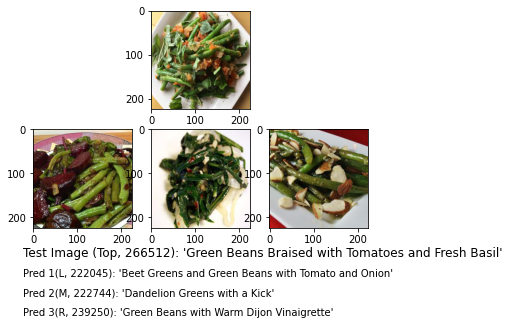

1.6690933


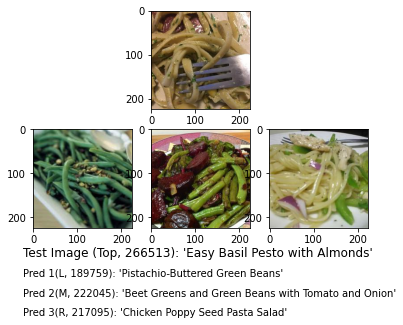

1.5485528


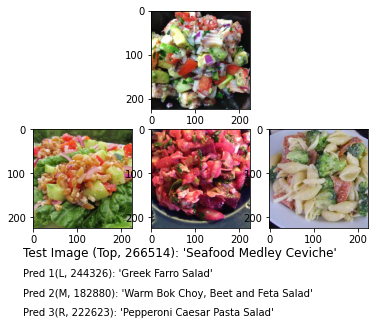

1.4921407


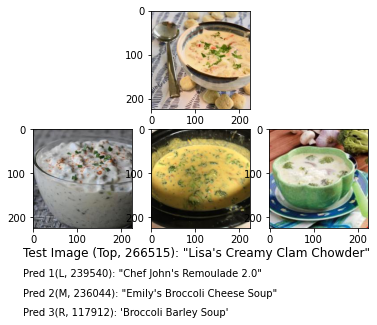

1.6426953


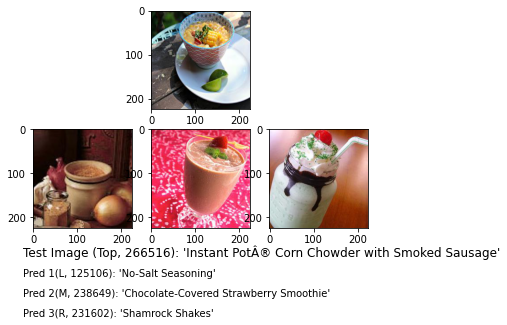

1.53137


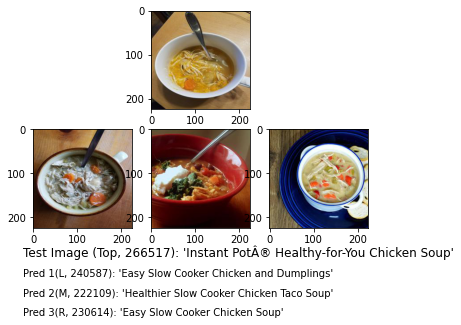

1.5799755


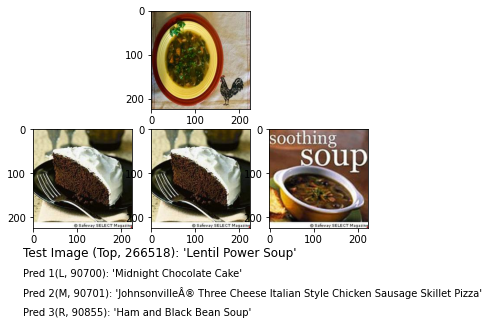

1.5468943


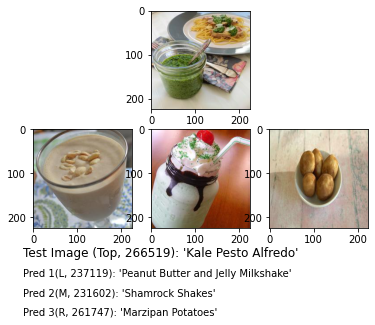

1.4542998


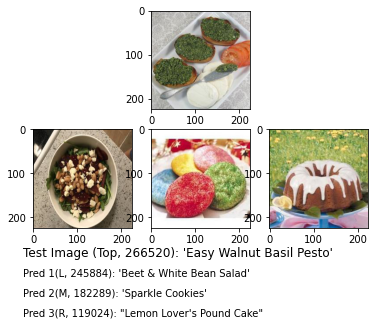

1.8631877


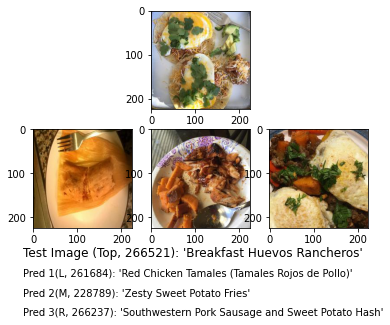

1.7920109


In [14]:
### Note: must rerun this block 4-5 times due to colab caching image data timing out, every run caches more data.

#for i in range(0,testset.shape[0],6):
for i in range(0,60,6):
  testrow = testset.iloc[i]
  test_code = testrow[2]
  test_vect = testrow['vgg_features']
  test_vect = model(torch.from_numpy(test_vect).cuda()).cpu().numpy()

  best_fit = [0, float('inf')]
  three_fit = [[0, float('inf')],[0, float('inf')],[0, float('inf')]]
  # for vector, code in zip(db['vgg16_final_features'], db['code']):
  #   dist = np.linalg.norm(test_vect - np.squeeze(vector))
  #   if dist < best_fit[1]:
  #     best_fit = [code, dist]

  for vector, code in zip(db['vgg16_final_features'], db['code']):
    dist = np.linalg.norm(test_vect - np.squeeze(vector))
    if dist < three_fit[2][1] and code not in [three_fit[0][0],three_fit[1][0],three_fit[2][0]]:
      if dist < three_fit[1][1]:
        if dist < three_fit[0][1]:
          three_fit[2] = three_fit[1]
          three_fit[1] = three_fit[0]
          three_fit[0] = [code, dist]
        else:
          three_fit[2] = three_fit[1]
          three_fit[1] = [code, dist]
      else:
        three_fit[2] = [code,dist]


  test = total_data.loc[total_data['code'] == test_code]

  testimagepath = IMAGE_PATH + str(test_code) + ".jpg"
  testimage = Image.open(testimagepath)
  #print("Test Image (left): ", test.title.values)
  #print(test.recipe.values)

  # pred = total_data.loc[total_data['code'] == best_fit[0]]
  # #print("Predicted Recipe Image (right): ", pred.title.values)
  # predimagepath = IMAGE_PATH + str(best_fit[0]) + ".jpg"
  # predimage = Image.open(predimagepath)

  pred1 = total_data.loc[total_data['code'] == three_fit[0][0]]
  #print("Predicted Recipe Image (right): ", pred.title.values)
  pred1imagepath = IMAGE_PATH + str(three_fit[0][0]) + ".jpg"
  pred1image = Image.open(pred1imagepath)

  pred2 = total_data.loc[total_data['code'] == three_fit[1][0]]
  #print("Predicted Recipe Image (right): ", pred.title.values)
  pred2imagepath = IMAGE_PATH + str(three_fit[1][0]) + ".jpg"
  pred2image = Image.open(pred2imagepath)

  pred3 = total_data.loc[total_data['code'] == three_fit[2][0]]
  #print("Predicted Recipe Image (right): ", pred.title.values)
  pred3imagepath = IMAGE_PATH + str(three_fit[2][0]) + ".jpg"
  pred3image = Image.open(pred3imagepath)

# text is usually -0.2, -0.3 for side by side
  f = plt.figure()
  ax1 = f.add_subplot(2,3,2)
  #ax1.title.set_text("Test: " + str(test.title.values)[1:-1])
  ax1.text(-1.3,-1.5, "Test Image (Top, " + str(test_code) + "): " + str(test.title.values)[1:-1], size=12, ha="left", 
          transform=ax1.transAxes)
  plt.imshow(testimage)
  ax2 = f.add_subplot(2,3,4)
  #ax2.title.set_text("Predicted Recipe: " + str(pred.title.values))
  ax1.text(-1.3,-1.7, "Pred 1(L, " + str(three_fit[0][0]) +"): " + str(pred1.title.values)[1:-1], size=10, ha="left", 
          transform=ax1.transAxes)
  plt.imshow(pred1image)
  ax2 = f.add_subplot(2,3,5)
  #ax2.title.set_text("Predicted Recipe: " + str(pred.title.values))
  ax1.text(-1.3,-1.9, "Pred 2(M, " + str(three_fit[1][0]) +"): " + str(pred2.title.values)[1:-1], size=10, ha="left", 
          transform=ax1.transAxes)
  plt.imshow(pred2image)
  ax2 = f.add_subplot(2,3,6)
  #ax2.title.set_text("Predicted Recipe: " + str(pred.title.values))
  ax1.text(-1.3,-2.1, "Pred 3(R, " + str(three_fit[2][0]) +"): " + str(pred3.title.values)[1:-1], size=10, ha="left", 
          transform=ax1.transAxes)
  plt.imshow(pred3image)

  plt.savefig(path + "vgg_test_outputs/0_three_output_" + str(test_code) + ".png")
  plt.show(block=True)

  print(three_fit[0][1])

#ingredients = pred.ingredients.values[0].split(",")
#recipe = pred.recipe.values[0].split(".")

# print("INGREDIENTS:")
# for i in ingredients:
#   print(i + ",")

# print("")
# print("RECIPE:")
# for i in recipe:
#   print(i + ".")
#print(ingredients)
#print("Predicted Ingredients:", pred.ingredients.values[0].split(","))
#print("Predicted Recipe:", pred.recipe.values)

#plt.imshow(testimage)
#plt.show(block=True)


### Test, only takes most similar

In [ ]:
### Only take best fit
#for i in range(0,testset.shape[0],6):
for i in range(0,1000,6):
  testrow = testset.iloc[i]
  test_code = testrow[2]
  test_vect = testrow['vgg_features']
  test_vect = model(torch.from_numpy(test_vect).cuda()).cpu().numpy()

  best_fit = [0, float('inf')]
  for vector, code in zip(db['vgg16_final_features'], db['code']):
    dist = np.linalg.norm(test_vect - np.squeeze(vector))
    if dist < best_fit[1]:
      best_fit = [code, dist]


  test = total_data.loc[total_data['code'] == test_code]
  testimagepath = IMAGE_PATH + str(test_code) + ".jpg"
  testimage = Image.open(testimagepath)

  #print("Test Image (left): ", test.title.values)
  #print(test.recipe.values)

  pred = total_data.loc[total_data['code'] == best_fit[0]]
  #print("Predicted Recipe Image (right): ", pred.title.values)
  predimagepath = IMAGE_PATH + str(best_fit[0]) + ".jpg"
  predimage = Image.open(predimagepath)

# text is usually -0.2, -0.3 for side by side
  f = plt.figure()
  ax1 = f.add_subplot(1,2,1)
  #ax1.title.set_text("Test: " + str(test.title.values)[1:-1])
  ax1.text(0,-0.2, "Test Image (Left, " + str(test_code) + "): " + str(test.title.values)[1:-1], size=10, ha="left", 
          transform=ax1.transAxes)
  plt.imshow(testimage)
  ax2 = f.add_subplot(1,2,2)
  #ax2.title.set_text("Predicted Recipe: " + str(pred.title.values))
  ax1.text(0,-0.3, "Predict (Right, " + str(best_fit[0]) +"): " + str(pred.title.values)[1:-1], size=10, ha="left", 
          transform=ax1.transAxes)
  plt.imshow(predimage)
  #plt.savefig(path + "vgg_test_outputs/0_three_output_" + str(test_code) + ".png")
  plt.show(block=True)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
drive.flush_and_unmount()